In [ ]:
!pip install transformers torch datasets scikit-learn matplotlib seaborn tqdm chardet

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Configuration class
class Config:
    # Model selection - DistilBERT is efficient for T4 GPU
    MODEL_NAME = "FacebookAI/roberta-base"
    MAX_LENGTH = 256  # Shorter for efficiency
    BATCH_SIZE = 16   # Appropriate for T4
    LEARNING_RATE = 1e-5
    EPOCHS = 7
    WARMUP_STEPS = 500

    # Policy categories
    POLICIES = {
        0: "Valid Review",
        1: "Advertisement",
        2: "Irrelevant Content",
        3: "Rant Without Visit"
    }

print("Configuration loaded successfully!")


Using device: cuda
GPU: Tesla T4
GPU Memory: 15.8 GB
Configuration loaded successfully!


In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Dataset class defined!")

Dataset class defined!


In [ ]:
def prepare_data(df, review_col='text_clean', label_col='label'):
    """
    Prepare data for training
    """
    # If no labels provided, create synthetic ones
    if label_col is None or label_col not in df.columns:
        print("No labels found. Creating synthetic labels based on heuristics...")
        labels = create_synthetic_labels(df, review_col)
        df['synthetic_labels'] = labels
        label_col = 'synthetic_labels'

    texts = df[review_col].tolist()
    labels = df[label_col].tolist()

    return texts, labels

print("Data preparation functions ready!")

# Cell 6: Load Your Labeled Dataset
print("Loading labeled dataset...")

import chardet

# Detect encoding
with open('sampled_cleaned.csv', 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']
    print(f"Detected encoding: {encoding}")

# Load your actual labeled CSV file with detected encoding
df = pd.read_csv('sampled_cleaned.csv', encoding=encoding)

print(f"Dataset loaded with {len(df)} reviews")
print(f"Columns: {list(df.columns)}")

# Check the first few rows to understand structure
print("\nFirst 5 rows:")
print(df.head())

# Manual label mapping (add this after loading your CSV)
label_mapping = {
    'relevant': 0,
    'advert': 1,
    'irrelevant': 2,
    'rant_no_visit': 3
}

df['label'] = df['label'].map(label_mapping)
df['label'] = df['label'].astype('Int64')
print(df['label'].value_counts())
nan_count = df['text_clean'].isna().sum()
print(nan_count)


df = df.dropna(subset=['label']).copy() # Remove rows where mapping resulted in NaN and use copy to avoid warning

# Filter out rows with NaN in 'text_clean'
df = df.dropna(subset=['text_clean']).copy()

# Prepare data using your actual labels
texts, labels = prepare_data(df, 'text_clean', 'label')

print(f"\nFinal dataset size: {len(texts)} reviews")
print(f"Label distribution:")
for label_id, count in pd.Series(labels).value_counts().sort_index().items():
    if label_id in Config.POLICIES:
        print(f"  {Config.POLICIES[label_id]}: {count}")
    else:
        print(f"  Label {label_id}: {count}")



Data preparation functions ready!
Loading labeled dataset...
Detected encoding: MacRoman
Dataset loaded with 411 reviews
Columns: ['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id', 'text_clean', 'label']

First 5 rows:
                 user_id                name          time  rating  \
0  106518268308075202016        Shawn Bauman  1.548890e+12       5   
1  116465907597878264380    Danielle Sanders  1.573830e+12       5   
2  118357919834630147032       Josh Ashcraft  1.505430e+12       3   
3  105854762895621736423  Krysten Huntington  1.599000e+12       4   
4  114696174715857105226        Dale Gribble  1.617600e+12       5   

                                                text pics resp  \
0  Excellent customer service here.  Fast take ou...  NaN  NaN   
1                                                NaN  NaN  NaN   
2                                                NaN  NaN  NaN   
3                                                NaN  NaN  NaN   
4       

In [ ]:
import os

class ReviewClassifier:
    def __init__(self, model_name=Config.MODEL_NAME, num_labels=4):
        self.model_name = model_name
        self.num_labels = num_labels
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
        )

        # Move model to GPU
        self.model.to(device)
        print(f"Model {model_name} loaded and moved to {device}")

    def prepare_datasets(self, texts, labels, test_size=0.2, val_size=0.1):
        """Split data and create datasets"""
        # Split data
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, labels, test_size=test_size + val_size, random_state=42, stratify=None
        )

        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=test_size/(test_size + val_size),
            random_state=42, stratify=None
        )

        # Create datasets
        train_dataset = ReviewDataset(X_train, y_train, self.tokenizer, Config.MAX_LENGTH)
        val_dataset = ReviewDataset(X_val, y_val, self.tokenizer, Config.MAX_LENGTH)
        test_dataset = ReviewDataset(X_test, y_test, self.tokenizer, Config.MAX_LENGTH)

        return train_dataset, val_dataset, test_dataset

    def predict_single(self, text):
        """Predict a single review"""
        self.model.eval()

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=Config.MAX_LENGTH,
            return_tensors='pt'
        )

        with torch.no_grad():
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            prediction = torch.argmax(outputs.logits, dim=-1).item()
            confidence = torch.nn.functional.softmax(outputs.logits, dim=-1).max().item()

        return prediction, confidence

# Initialize classifier
classifier = ReviewClassifier()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model FacebookAI/roberta-base loaded and moved to cuda


In [ ]:
train_dataset, val_dataset, test_dataset = classifier.prepare_datasets(texts, labels)

print(f"Dataset splits:")
print(f"  Train size: {len(train_dataset)}")
print(f"  Validation size: {len(val_dataset)}")
print(f"  Test size: {len(test_dataset)}")

# Check class distribution in splits
def check_label_distribution(dataset, name):
    labels = [dataset[i]['labels'].item() for i in range(len(dataset))]
    print(f"\n{name} label distribution:")
    for label_id, count in pd.Series(labels).value_counts().sort_index().items():
        print(f"  {Config.POLICIES[label_id]}: {count}")

Dataset splits:
  Train size: 179
  Validation size: 26
  Test size: 52


In [ ]:
def setup_training(model, train_dataset, val_dataset):
    """Setup training arguments and trainer"""

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=Config.EPOCHS,
        per_device_train_batch_size=Config.BATCH_SIZE,
        per_device_eval_batch_size=Config.BATCH_SIZE,
        warmup_steps=Config.WARMUP_STEPS,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=50,
        eval_strategy="steps", # Corrected from evaluation_strategy
        eval_steps=200,
        save_strategy="steps",
        save_steps=200,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        fp16=True,  # Enable mixed precision for T4
        dataloader_pin_memory=False,  # Disable for stability on Colab
        report_to= "none",  # Disable wandb logging
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )

    return trainer

# Setup trainer
trainer = setup_training(classifier.model, train_dataset, val_dataset)
print("Training setup complete!")

Training setup complete!


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
os.environ["WANDB_DISABLED"] = "true"

print("Starting training...")
print("=" * 40)

# Train the model
training_output = trainer.train()

print("\nTraining completed!")
print(f"Final training loss: {training_output.training_loss:.4f}")

Starting training...


Step,Training Loss,Validation Loss



Training completed!
Final training loss: 1.1235


In [ ]:
def evaluate_model(model, test_dataset):
    """Evaluate the model on test dataset"""
    model.eval()
    predictions = []
    true_labels = []

    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

def plot_confusion_matrix(y_true, y_pred, labels):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix - Review Quality Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(y_true, y_pred):
    """Print detailed evaluation metrics"""
    print("Classification Report:")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=list(Config.POLICIES.values())))

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, list(Config.POLICIES.values()))

    # Additional metrics
    from sklearn.metrics import accuracy_score, f1_score
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"\nOverall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")

print("Evaluation functions loaded!")

Evaluation functions loaded!


Evaluating model on test set...


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 15.82it/s]


Classification Report:
                    precision    recall  f1-score   support

      Valid Review       0.83      1.00      0.91        35
     Advertisement       0.00      0.00      0.00         1
Irrelevant Content       1.00      0.71      0.83        14
Rant Without Visit       0.00      0.00      0.00         2

          accuracy                           0.87        52
         macro avg       0.46      0.43      0.44        52
      weighted avg       0.83      0.87      0.84        52



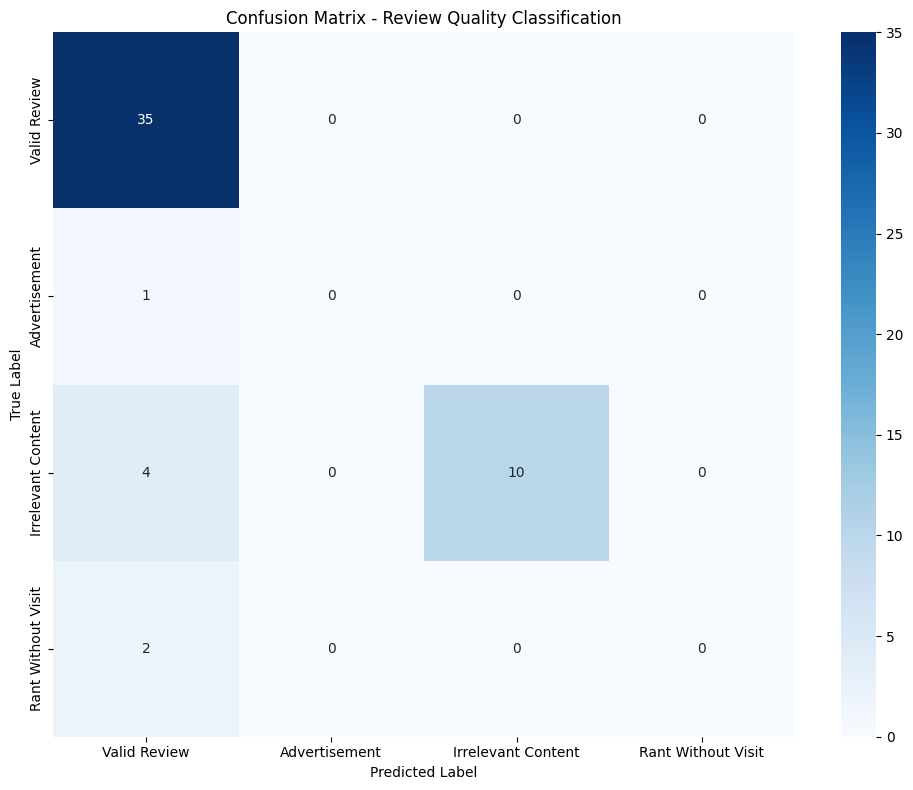


Overall Metrics:
Accuracy: 0.8654
F1-Score (Macro): 0.4356
F1-Score (Weighted): 0.8362


In [ ]:
print("Evaluating model on test set...")
predictions, true_labels = evaluate_model(classifier.model, test_dataset)

# Print detailed evaluation
evaluate_model_performance(true_labels, predictions)

In [ ]:
# Detect encoding
with open('sampled_test.csv', 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']
    print(f"Detected encoding: {encoding}")

# Load your actual labeled CSV file with detected encoding
test_df = pd.read_csv('sampled_test.csv', encoding=encoding)

test_df['label'] = test_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].astype('Int64')

# Drop rows with NaN in the 'label' column after mapping
test_df = test_df.dropna(subset=['label']).copy()


test_texts, test_labels = prepare_data(test_df, 'text_clean', 'label')

# Create a test dataset
test_set = ReviewDataset(test_texts, test_labels, classifier.tokenizer, Config.MAX_LENGTH)

Detected encoding: MacRoman


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 17.64it/s]


Classification Report:
                    precision    recall  f1-score   support

      Valid Review       0.82      0.96      0.89        85
     Advertisement       0.00      0.00      0.00         6
Irrelevant Content       0.76      0.70      0.73        37
Rant Without Visit       0.00      0.00      0.00         6

          accuracy                           0.81       134
         macro avg       0.40      0.42      0.40       134
      weighted avg       0.73      0.81      0.76       134



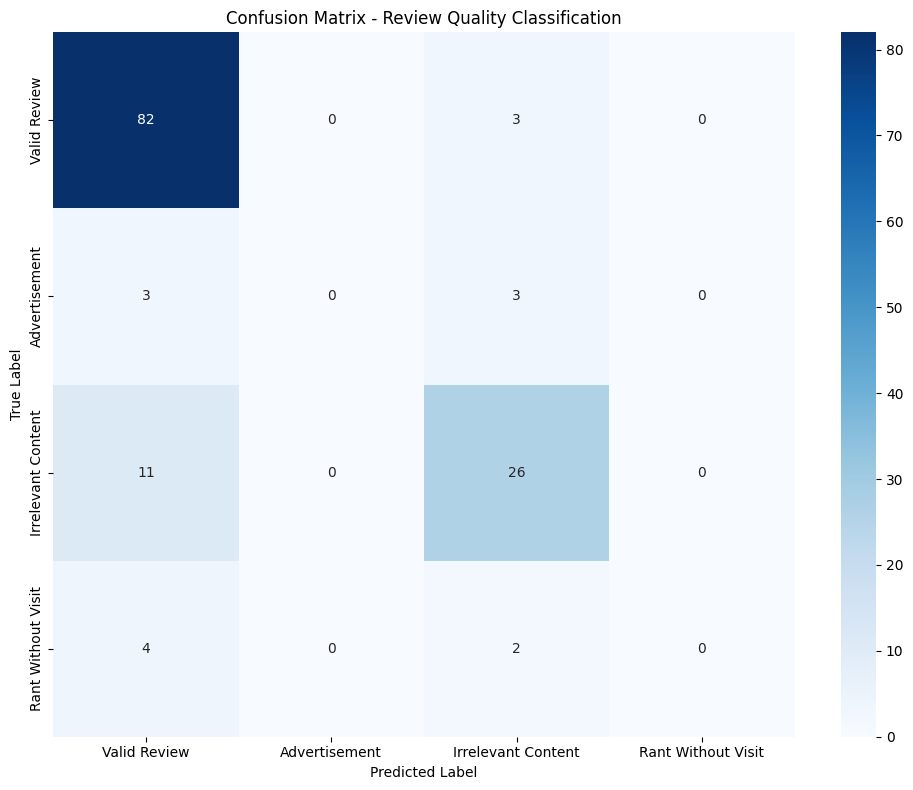


Overall Metrics:
Accuracy: 0.8060
F1-Score (Macro): 0.4047
F1-Score (Weighted): 0.7646


In [ ]:
test_predictions, test_true_labels = evaluate_model(classifier.model, test_set)

# Print detailed evaluation
evaluate_model_performance(test_true_labels, test_predictions)